In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [20]:
# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [21]:
# 1) Create synthetic imbalanced dataset (1% anomalies)
X, y_raw = make_classification(n_samples=10000, n_features=20, n_informative=15,
                               n_redundant=5, weights=[0.01, 0.99],
                               flip_y=0, random_state=RANDOM_SEED)

In [22]:
# Map labels so: 1 = normal, 0 = anomaly (matches your lab note)
y = y_raw.copy()

In [23]:
# 2) Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25,
                                                              stratify=y, random_state=RANDOM_SEED)

In [24]:
# Train autoencoder only on normal samples:
X_train = X_train_full[y_train_full == 1]

In [25]:
# 3) Scale (fit scaler on normal train)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# 4) Build autoencoder
input_dim = X_train_scaled.shape[1]
encoding_dim = 8

In [27]:
inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
encoded = layers.Dense(encoding_dim, activation="relu", name="latent")(x)

In [28]:
x = layers.Dense(32, activation="relu")(encoded)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(input_dim, activation="linear")(x)

In [29]:
autoencoder = keras.Model(inputs, outputs, name="autoencoder")
autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mse"])

In [30]:
# 5) Train (with early stopping)
es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=10, batch_size=64, validation_split=0.1,
                          callbacks=[es], verbose=2)

Epoch 1/10
105/105 - 7s - 66ms/step - loss: 0.7697 - mse: 0.7697 - val_loss: 0.4717 - val_mse: 0.4717
Epoch 2/10
105/105 - 1s - 7ms/step - loss: 0.3725 - mse: 0.3725 - val_loss: 0.3337 - val_mse: 0.3337
Epoch 3/10
105/105 - 1s - 13ms/step - loss: 0.3120 - mse: 0.3120 - val_loss: 0.3025 - val_mse: 0.3025
Epoch 4/10
105/105 - 1s - 12ms/step - loss: 0.2844 - mse: 0.2844 - val_loss: 0.2771 - val_mse: 0.2771
Epoch 5/10
105/105 - 1s - 13ms/step - loss: 0.2608 - mse: 0.2608 - val_loss: 0.2536 - val_mse: 0.2536
Epoch 6/10
105/105 - 1s - 11ms/step - loss: 0.2295 - mse: 0.2295 - val_loss: 0.2157 - val_mse: 0.2157
Epoch 7/10
105/105 - 1s - 14ms/step - loss: 0.2030 - mse: 0.2030 - val_loss: 0.1978 - val_mse: 0.1978
Epoch 8/10
105/105 - 1s - 12ms/step - loss: 0.1903 - mse: 0.1903 - val_loss: 0.1880 - val_mse: 0.1880
Epoch 9/10
105/105 - 1s - 8ms/step - loss: 0.1825 - mse: 0.1825 - val_loss: 0.1814 - val_mse: 0.1814
Epoch 10/10
105/105 - 1s - 12ms/step - loss: 0.1769 - mse: 0.1769 - val_loss: 0.1764

In [31]:
# 6) Reconstruction error
recon_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean(np.square(recon_train - X_train_scaled), axis=1)

233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   


In [32]:
recon_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean(np.square(recon_test - X_test_scaled), axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [33]:
# 7) Threshold selection (two common ways)
threshold_mean_std = mse_train.mean() + 3 * mse_train.std()
threshold_95 = np.percentile(mse_train, 95)
threshold = threshold_95  # choose one to use

In [34]:
# 8) Predictions: predict anomaly if reconstruction error > threshold
y_pred = np.where(mse_test > threshold, 0, 1)

In [35]:
# 9) Evaluation
print("Confusion matrix (true 0/1 rows, pred 0/1 cols):")
print(confusion_matrix(y_test, y_pred, labels=[0,1]))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion matrix (true 0/1 rows, pred 0/1 cols):
[[  18    7]
 [ 143 2332]]

Classification report:
              precision    recall  f1-score   support

           0     0.1118    0.7200    0.1935        25
           1     0.9970    0.9422    0.9688      2475

    accuracy                         0.9400      2500
   macro avg     0.5544    0.8311    0.5812      2500
weighted avg     0.9882    0.9400    0.9611      2500



In [36]:
# AUC (use recon error as score for anomaly)
y_test_anom = (y_test == 0).astype(int)  # 1 for anomaly
auc = roc_auc_score(y_test_anom, mse_test)
print(f"ROC AUC = {auc:.4f}")

ROC AUC = 0.9407


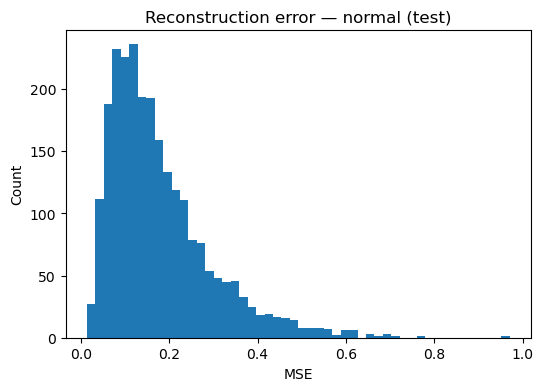

In [37]:
# 10) Plots - one chart per figure (matplotlib default)
mse_test_normal = mse_test[y_test == 1]
plt.figure(figsize=(6,4))
plt.hist(mse_test_normal, bins=50)
plt.title("Reconstruction error — normal (test)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()

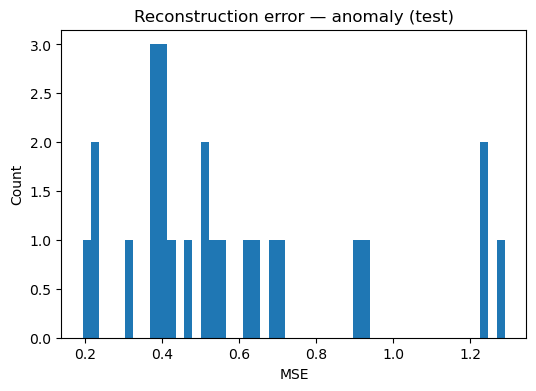

In [38]:
mse_test_anom = mse_test[y_test == 0]
plt.figure(figsize=(6,4))
plt.hist(mse_test_anom, bins=50)
plt.title("Reconstruction error — anomaly (test)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()